# Bifurcation process synthetic data generation

Following the [validation via STREAM](https://github.com/bnediction/gustavo/blob/M2/M2/stream-poc/STREAM_first_trajectory.ipynb) of the [synthetic data](https://github.com/bnediction/gustavo/blob/M2/M2/stream-poc/random_walk_generation_exploration.ipynb) generated on top of a minimal boolean network
showing the progressive activation of a set of 10 genes upregulated by a single transcription factor, we will
now try to generate a bifurcation process. *For reference* : See the ["M2" branch of bnedicition/gustavo](https://github.com/bnediction/gustavo/tree/M2), the latest commit (when I created this notebook) shasum is `86ea77e6f6aad25cfdfdb43a3eddd8b6bd4e1ccc`.




### Important !!!

The execution of this notebook relies on the tree structure being the same as in [Subdirectory M2](https://github.com/bnediction/gustavo/tree/M2/M2)

In [1]:
# type hints
from typing import Iterator, Dict
RandomWalkGenerator = Iterator[Dict[str,int]]

# visualisation
import matplotlib.pyplot as plt
import plotnine as gg
import random

# data io
import numpy as np
import pandas as pd

# generation of unique identifiers for reproducibility
from IPython import get_ipython
ipython = get_ipython()
import datetime as dt

# development utils
from scboolseq import scBoolSeq
from scboolseq.simulation import (
    biased_simulation_from_binary_state,
    _simulate_subset,
    simulate_gene, 
    simulate_bimodal_gene,
    simulate_unimodal_gene
)
from scboolseq.utils.customobjs import (
    Path, 
    ObjDict as odict
)
from scboolseq.utils.stream_helpers import *

# Boolean networks
import ginsim
import networkx as nx
from colomoto.minibn import *

# miscellaneous
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.spatial.distance import jaccard, squareform, pdist
from sklearn.metrics.pairwise import pairwise_distances
import pickle
from itertools import chain, combinations, product # For powerset calculation
from functools import partial # in order to pre-load functions before passing them to
                              # a pd.DataFrame.index.map()
from scipy.spatial.distance import jaccard as jaccard_distance # To compute the similarity between critical nodes
lmap = lambda f, x: list(map(f, x))
now = lambda: str(dt.datetime.now()).split('.')[0].replace(" ", "_").replace(":", "h", 1).replace(":", "m")

# set the project root and create diferent locations
root = Path(".").resolve()
locations = odict({
    "root": root,
    "data": root.joinpath("../data/").resolve(),
    "criteriae": root.joinpath("../criteriae").resolve(),
    "synthetic_data": root.joinpath("../synthetic_data/").resolve()
})

# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)

# Visualise the paths
for name, location in locations.items():
    if not location.exists():
        raise FileNotFoundError(f"Specified location \n{location}\n does not exist !")
    #print(f"{name} -> {location}")

In [2]:
criteriae = odict({
    criteria.name.replace("scBoolSeq_Nestorowa_", "").replace(".csv", ""): pd.read_csv(criteria, index_col=0)
    for criteria in locations.criteriae.glob("*csv")
})
criteriae.lkeys

['simulation_criteria']

### Load criteriae learnt on the Nestorowa Dataset (after feature selection via STREAM)

In [3]:
criteria = criteriae.simulation_criteria
print(f"* Categories on simulation criteria:\n{criteria.Category.value_counts()}\n")
criteria.head()

* Categories on simulation criteria:
Bimodal      2922
Unimodal     1645
Discarded     201
Name: Category, dtype: int64



,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
Clec1b,0.994849,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal
Mns1,0.000000,2.066577,-1.366120,0.100242,4.743786,1.884848,10.862714,0.607455,0.392545,1.949125,7.857075,1.948831,4.743786,9.166517,0.25,1.994418,7.569707,5.575288,3.798141,4.043072,6.026639,Bimodal
Zfp758,0.000000,2.656696,-1.077530,0.410024,3.392367,0.032378,10.114596,0.802972,0.197028,0.716757,7.236947,0.952938,3.392367,8.305333,0.25,1.103814,6.430069,5.326255,1.911847,3.691636,4.635897,Bimodal
Zfp655,0.000000,2.375439,-1.429402,0.179348,4.114937,0.887514,10.453106,0.653967,0.346033,1.296866,7.308042,1.449121,4.114937,8.699362,0.25,1.419807,7.125837,5.706030,2.970440,3.740356,5.248518,Bimodal
Srxn1,0.001124,2.538884,-0.893849,0.690217,3.146476,0.006911,10.074096,0.895532,0.104468,0.303613,6.727692,0.598964,3.146476,7.578089,0.25,0.962015,5.719712,4.757697,1.682418,3.431388,4.041717,Bimodal


## Function declaration

In [3]:
def state_to_str(state) -> str:
    """ """
    return "".join(str(value) for value in state.values())

def graph_node_to_dict(async_dynamics, node: str):
    """ """
    return dict(
        zip(
            async_dynamics.nodes,
            map(
                int, list(node)
            )
        )
    )

def find_terminal_nodes_indexes(digraph: nx.DiGraph):
    """ """
    return [i for i in digraph.nodes if len(list(digraph.successors(i))) == 0 ]

def condensation_node_to_dicts(async_dynamics, condensation, node: int):
    """ """
    return [dict(zip(async_dynamics.nodes, w)) for w in condensation.nodes[node]["members"]]

def condensation_node_to_str(node) -> str:
    """ """
    return "".join(w for w in node["members"])

def powerset(iterable):
    """
    
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def shortest_path_passing_by(graph, start, visit, end):
    """ """
    format_node = lambda x: x if isinstance(x, str) else state_to_str(x)
    
    _fist_path = nx.shortest_path(
        graph, format_node(start), format_node(visit)
    )
    _second_path = nx.shortest_path(
        graph, format_node(visit), format_node(end)
    )
    
    if not _fist_path[-1] == _second_path[0]:
        raise ValueError(
            f"`{_fist_path[-1]}` != `{_second_path[0]}`, inconsistent path"
        )
    
    _ = _fist_path.pop()
    
    return _fist_path + _second_path

## Set experiment name

In [4]:
_prefix = "hematopoiesis"
experiment_name = f"{_prefix}_{now()}"
experiment_name

'hematopoiesis_2022-04-28_10h04m04'

## Overview of the system configuration

Model taken from __"Single-cell
RNA-seq assisted synthesis of a Boolean network to model early hematopoiesis aging"__ by Leonard H ́erault, Mathilde Poplineau, Estelle Duprez, and  ́Elisabeth Remy. 
2022.

First model
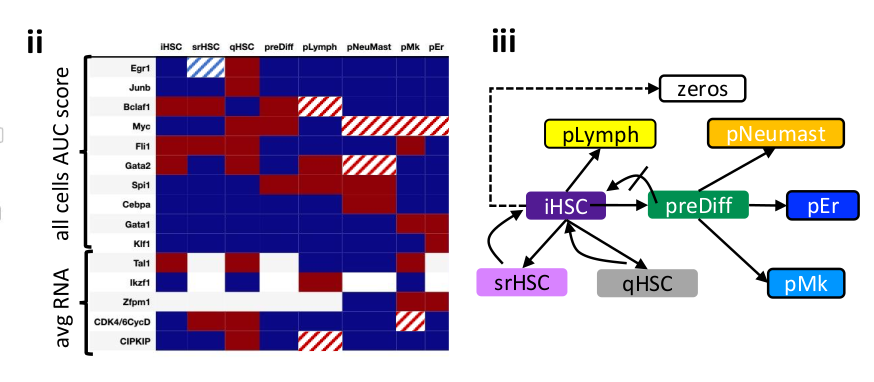


Pruned model
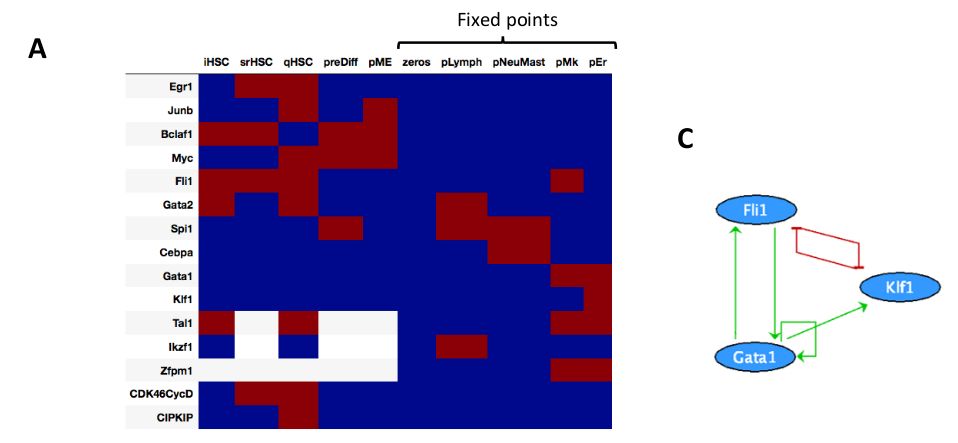

Marker genes
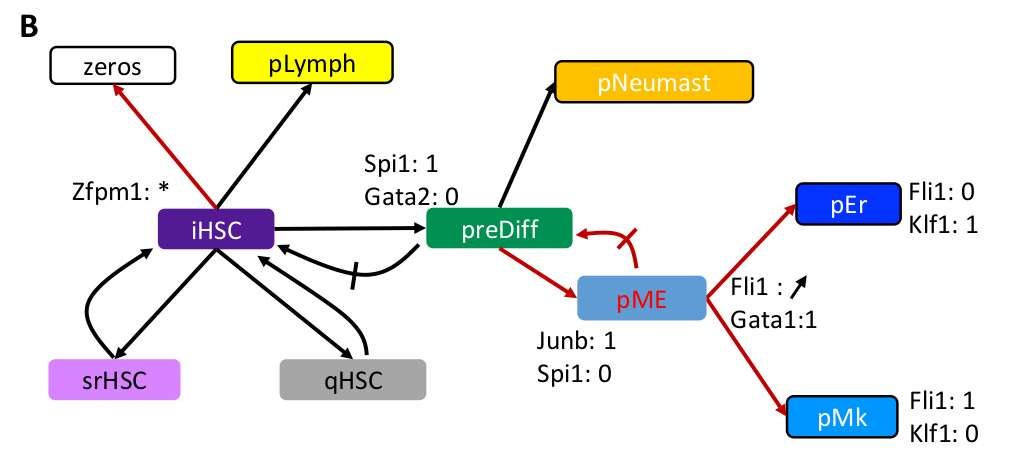

* Blue: inactive (0)
* White: unknown/free
* Red: active (1)

## Load the model

Either declare it or use one of the preloaded models.

In [6]:
from models import EARLY_HEMATOPOIESIS as hematopoiesis
config_bn = bn_config = hematopoiesis.network
bn = BooleanNetwork(bn_config)
bn

Bclaf1 <- Myc
CDK46CycD <- Bclaf1|Myc
CIPKIP <- Junb
Cebpa <- (Gata2&!Ikzf1)|(Spi1&!Ikzf1)
Egr1 <- Gata2&Junb
Fli1 <- Junb|(Gata1&!Klf1)
Gata1 <- Fli1|(Gata2&!Spi1)|(Gata1&!Ikzf1&!Spi1)
Gata2 <- (Gata2&!Gata1&!Zfpm1)|(Egr1&!Gata1&!Zfpm1&!Spi1)
Ikzf1 <- Gata2
Junb <- Egr1|Myc
Klf1 <- Gata1&!Fli1
Myc <- Cebpa&Bclaf1
Spi1 <- (Spi1&!Gata1)|(Cebpa&!Gata1&!Gata2)
Tal1 <- Gata1&!Spi1
Zfpm1 <- Gata1

# computing graph layout...


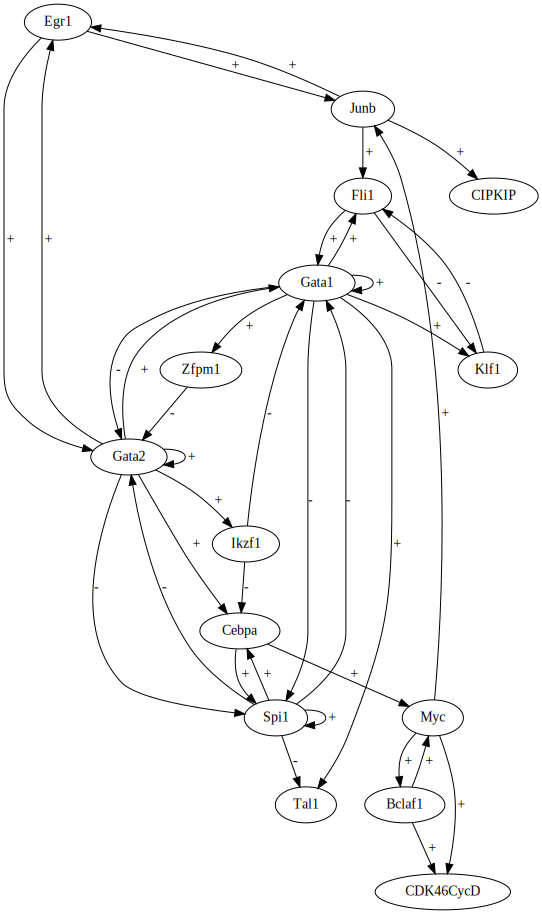

In [7]:
influence_graph = bn.influence_graph()
nx.nx_pydot.write_dot(influence_graph, "hematopoiesis_raw.dot")
influence_graph

In [8]:
dynamics = FullyAsynchronousDynamics(bn)

Manually declare all the states of interest

In [9]:
state_full_zero = bn.zero()
# Start copying the full-zero state
states = odict({
    "initial_iHSC": state_full_zero.copy(),
    "branching_point_preDiff": state_full_zero.copy(),
    "branching_point_pME": state_full_zero.copy(),
    "attractor_pNeumast": state_full_zero.copy(),
    "attractor_pEr": state_full_zero.copy(),
    "attractor_pMk": state_full_zero.copy()
})

# Declare genes which are set to one 
_states_ones = odict({
    # Zfpm1 is a free gene for the initial state
    "initial_iHSC": "Bclaf1|Fli1|Gata2|Tal1|Zfpm1".split("|"), 
    # Ikzf1|Tal1|Zfpm1 <- These genes are free for the branching point preDiff
    "branching_point_preDiff": "Bclaf1|Myc|Spi1".split("|"),
    # Ikzf1|Tal1|Zfpm1 <- These genes are free for the branching point pME
    "branching_point_pME": "Junb|Bclaf1|Myc".split("|"),
    "attractor_pNeumast": "Spi1|Cebpa".split("|"),
    "attractor_pEr": "Gata1|Klf1|Tal1|Zfpm1".split("|"),
    "attractor_pMk": "Fli1|Gata1|Tal1|Zfpm1".split("|")
})

# Iterate over 'states' dict to update the values
# performing integrity checks on each step
for _state_key in states.keys():
    if all(i in bn_config for i in _states_ones[_state_key]):
        states[_state_key].update({gene: 1 for gene in _states_ones[_state_key]})
    else:
        raise ValueError(
            "\n".join([
                f"When updating state `{_state_key}`, "
                f"at least one of {_states_ones[_state_key]} not found in the boolean network variables."
                "This is probably due to a typo, check they are all correctly spelled"
            ])
        )

## Graph-based manual construction of trajectories of interest

Compute transition graph from the initial state and show its cadinality.

Compute a subset ot the accessible transition graph from the initial state, considering the graph induced by taking the succesors of the branching point.
This may reduce the computation time of inferring the shortest trajectories from the initial state to each
one of the fixed point attractors

In [14]:
transition_graphs = odict({
    "full": dynamics.partial_dynamics(states["initial_iHSC"]),
    "from_branching_point": dynamics.partial_dynamics(states["branching_point_preDiff"])
})
for name, stg in transition_graphs.items():
    print(f"stg `{name}` has {len(stg)} nodes")

stg `full` has 10680 nodes
stg `from_branching_point` has 370 nodes


In [15]:
condensations = odict({
    name: nx.condensation(stg)
    for name, stg in transition_graphs.items()
})
for name, stg in condensations.items():
    print(f"condensation `{name}` has {len(stg)} nodes")

condensation `full` has 9536 nodes
condensation `from_branching_point` has 370 nodes


In [16]:
shortest_path_passing_by(
    transition_graphs.full,
    states["initial_iHSC"],
    states["branching_point_preDiff"],
    states["attractor_pNeumast"]
)

['001011000010100',
 '001001000010100',
 '001001010010100',
 '001101010010100',
 '001101010000100',
 '001101010001100',
 '001100010001100',
 '001100010001000',
 '001100110001000',
 '001100100001000',
 '001100100000000',
 '001000100000000',
 '000000100000000',
 '000000110000000']

In [17]:
# yield the powerset defined by all free genes:
_preDiff_branching_powerset = [
    "|".join(i for i in _set)
    for _set in powerset("Ikzf1|Tal1|Zfpm1".split("|"))
]

# iterate over the powerset
for _set in _preDiff_branching_powerset:
    # Copy the zero state
    states["branching_point_preDiff"] = state_full_zero.copy()
    # Genes that should alwats be set to one :
    # Bclaf1, Myc, and Spi1 
    # free genes will be considered by _set
    _branching_ones = "|".join(["Bclaf1|Myc|Spi1", _set]).strip("|").split("|")
    
    if all(i in bn_config for i in _branching_ones): # Check if genes to be set to 1 exist (no typos)
        states["branching_point_preDiff"].update({gene: 1 for gene in _branching_ones})
    else:
        raise ValueError(
            f"Invalid gene set {_branching_ones}"
        )
        
    print(
        f"Trying branching point : {state_to_str(states['branching_point_preDiff'])}",
        f"{'|'.join(_branching_ones)}",
        sep=", "
    )
    # TODO : remove this or adapt it to MP tg
    _partial_tg = dynamics.partial_dynamics(states["branching_point_preDiff"])
    print(f"Transition graph from branching point contains {len(_partial_tg)} possible states.")
    # Iterate over attractors, find the shortest path :
    for state in (s for s in states.keys() if "attractor" in s):
        print(
            f"\t`iHSC`->`preDiff`->`{state}`",
            end="\t"
        )
        try:
            _path = shortest_path_passing_by(
                transition_graphs.full,
                states["initial_iHSC"],
                states["branching_point_preDiff"],
                states[state]
            )
            print(f"Path containing {len(_path)} states")
        except nx.NetworkXNoPath as _no_path_ex:
            print("No path found !!!")
        print("")

Trying branching point : 001100100000000, Bclaf1|Myc|Spi1
Transition graph from branching point contains 370 possible states.
	`iHSC`->`preDiff`->`attractor_pNeumast`	Path containing 14 states

	`iHSC`->`preDiff`->`attractor_pEr`	No path found !!!

	`iHSC`->`preDiff`->`attractor_pMk`	Path containing 20 states

Trying branching point : 001100100001000, Bclaf1|Myc|Spi1|Ikzf1
Transition graph from branching point contains 532 possible states.
	`iHSC`->`preDiff`->`attractor_pNeumast`	Path containing 14 states

	`iHSC`->`preDiff`->`attractor_pEr`	No path found !!!

	`iHSC`->`preDiff`->`attractor_pMk`	Path containing 20 states

Trying branching point : 001100100010000, Bclaf1|Myc|Spi1|Tal1
Transition graph from branching point contains 548 possible states.
	`iHSC`->`preDiff`->`attractor_pNeumast`	Path containing 14 states

	`iHSC`->`preDiff`->`attractor_pEr`	No path found !!!

	`iHSC`->`preDiff`->`attractor_pMk`	Path containing 18 states

Trying branching point : 001100100000100, Bclaf1|Myc|

The attractor `pEr` seems to be unreachable using fully asynchronous semantics, 
We will simulate the data excluding it.

## Study the attractors

In [18]:
_to_state = partial(graph_node_to_dict, dynamics)

_traj1 = map(_to_state,
    shortest_path_passing_by(
        transition_graphs.full,
        states["initial_iHSC"],
        states["branching_point_preDiff"],
        states["attractor_pMk"]
    )
)

_traj2 = map(_to_state,
    shortest_path_passing_by(
        transition_graphs.full,
        states["initial_iHSC"],
        states["branching_point_preDiff"],
        states["attractor_pNeumast"]
    )
)

_traj1_df = trajectory_to_data_frame(_traj1)
_traj2_df = trajectory_to_data_frame(_traj2)
_traj2_df

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
step,,,,,,,,,,,,,,,
0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0
1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0
2,0,0,1,0,1,1,0,1,0,0,1,1,1,0,0
3,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0
4,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0
5,0,0,1,1,1,0,1,1,0,0,1,1,1,0,0
6,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0
7,0,0,1,1,0,0,1,0,0,0,1,1,1,0,0
8,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0


# computing graph layout...


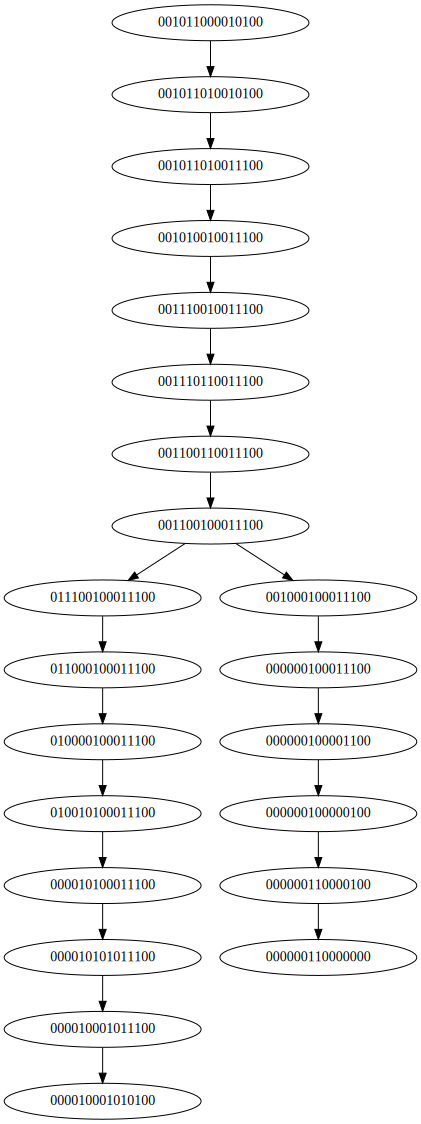

In [19]:
c1 = ["".join(map(str, d.values)) for _,d in _traj1_df.iterrows()]
c2 = ["".join(map(str, d.values)) for _,d in _traj2_df.iterrows()]
_graph = nx.DiGraph(list(zip(c1[:-1],c1[1:]))+list(zip(c2[:-1], c2[1:])))
nx.nx_pydot.write_dot(_graph, "branching_hematopoiesis.dot")
_graph

In [20]:
boolean_df_query_generator(states["attractor_pMk"])

'Egr1 == 0 and Junb == 0 and Bclaf1 == 0 and Myc == 0 and Fli1 == 1 and Gata2 == 0 and Spi1 == 0 and Cebpa == 0 and Gata1 == 1 and Klf1 == 0 and Tal1 == 1 and Ikzf1 == 0 and Zfpm1 == 1 and CDK46CycD == 0 and CIPKIP == 0'

In [21]:
random_walk_df = merged_trajectories_df = merge_binary_trajectories(
    trajectories=[_traj1_df, _traj2_df],
    labels = ["pMk", "pNeumast"],
    branching_point_query=boolean_df_query_generator(states["branching_point_preDiff"]),
    attractor_queries=[
        boolean_df_query_generator(states["attractor_pMk"]),
        boolean_df_query_generator(states["attractor_pNeumast"])
    ],
    confound_observations=True
).drop_duplicates()
merged_trajectories_df

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
label,,,,,,,,,,,,,,,
common,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0
common,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0
common,0,0,1,0,1,1,0,1,0,0,1,1,1,0,0
common,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0
common,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0
common,0,0,1,1,1,0,1,1,0,0,1,1,1,0,0
common,0,0,1,1,0,0,1,1,0,0,1,1,1,0,0
split,0,0,1,1,0,0,1,0,0,0,1,1,1,0,0
branch_pMk,0,1,1,1,0,0,1,0,0,0,1,1,1,0,0


In [22]:
merged_trajectories_df.reset_index().label.value_counts() / merged_trajectories_df.shape[0]

common                0.318182
branch_pMk            0.318182
branch_pNeumast       0.227273
split                 0.045455
attractor_pMk         0.045455
attractor_pNeumast    0.045455
Name: label, dtype: float64

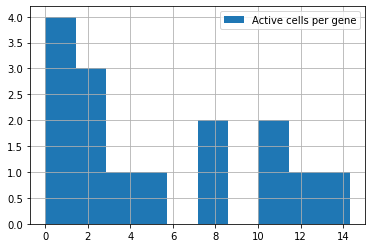

In [23]:
(merged_trajectories_df.mean() * merged_trajectories_df.shape[1] ).hist(**{"label": "Active cells per gene"})
plt.legend()

In [24]:
categories = merged_trajectories_df.reset_index().groupby("label").mean().index.to_list()
mean_exp_by_label = merged_trajectories_df.reset_index().groupby("label").mean() 
mean_exp_by_label

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
label,,,,,,,,,,,,,,,
attractor_pMk,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,0.000000,1.0,0.0,0.0
attractor_pNeumast,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
branch_pMk,0.0,0.571429,0.285714,0.142857,0.571429,0.000000,0.857143,0.000000,0.285714,0.0,1.0,1.000000,1.0,0.0,0.0
branch_pNeumast,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,1.000000,0.200000,0.000000,0.0,0.4,0.600000,1.0,0.0,0.0
common,0.0,0.000000,1.000000,0.428571,0.857143,0.428571,0.285714,0.857143,0.000000,0.0,1.0,0.714286,1.0,0.0,0.0
split,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,1.0,0.0,0.0


In [25]:
mean_bool_exp_by_label = mean_exp_by_label > 0.5
mean_bool_exp_by_label

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
label,,,,,,,,,,,,,,,
attractor_pMk,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False
attractor_pNeumast,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
branch_pMk,False,True,False,False,True,False,True,False,False,False,True,True,True,False,False
branch_pNeumast,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False
common,False,False,True,False,True,False,False,True,False,False,True,True,True,False,False
split,False,False,True,True,False,False,True,False,False,False,True,True,True,False,False


In [26]:
mean_bool_exp_by_label.T.sum()

label
attractor_pMk         4
attractor_pNeumast    2
branch_pMk            6
branch_pNeumast       3
common                6
split                 6
dtype: int64

In [27]:
jac_sim = pd.DataFrame(
    1 - pairwise_distances(mean_bool_exp_by_label, metric = "hamming"), 
    index=mean_bool_exp_by_label.T.columns, 
    columns=mean_bool_exp_by_label.T.columns
)
jac_sim

label,attractor_pMk,attractor_pNeumast,branch_pMk,branch_pNeumast,common,split
label,,,,,,
attractor_pMk,1.000000,0.6,0.733333,0.666667,0.733333,0.600000
attractor_pNeumast,0.600000,1.0,0.600000,0.800000,0.600000,0.600000
branch_pMk,0.733333,0.6,1.000000,0.800000,0.733333,0.733333
branch_pNeumast,0.666667,0.8,0.800000,1.000000,0.666667,0.800000
common,0.733333,0.6,0.733333,0.666667,1.000000,0.733333
split,0.600000,0.6,0.733333,0.800000,0.733333,1.000000


In [28]:
jac_sim.mean().describe()

count    6.000000
mean     0.744444
std      0.031427
min      0.700000
25%      0.727778
50%      0.744444
75%      0.761111
max      0.788889
dtype: float64

In [29]:
dist_pdist = squareform(pairwise_distances(mean_bool_exp_by_label, metric = "hamming"), force='tovector')
dist_pdist

array([0.4       , 0.26666667, 0.33333333, 0.26666667, 0.4       ,
       0.4       , 0.2       , 0.4       , 0.4       , 0.2       ,
       0.26666667, 0.26666667, 0.33333333, 0.2       , 0.26666667])

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [22.5, 22.5, 50.0, 50.0],
  [5.0, 5.0, 36.25, 36.25]],
 'dcoord': [[0.0, 0.2, 0.2, 0.0],
  [0.0, 0.23333333333333334, 0.23333333333333334, 0.2],
  [0.0, 0.26666666666666666, 0.26666666666666666, 0.0],
  [0.23333333333333334,
   0.3111111111111111,
   0.3111111111111111,
   0.26666666666666666],
  [0.0, 0.36, 0.36, 0.3111111111111111]],
 'ivl': ['1', '5', '2', '3', '0', '4'],
 'leaves': [1, 5, 2, 3, 0, 4],
 'color_list': ['C1', 'C1', 'C0', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1', 'C0', 'C0']}

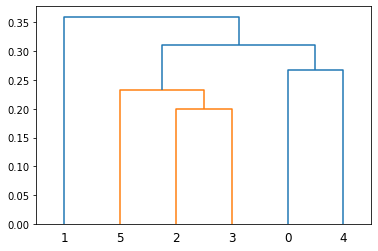

In [30]:
dendrogram(linkage(dist_pdist, method="average"))

In [31]:
# perform random sampling over bimodal genes
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(len(random_walk_df.columns), random_state=_rng_seed)
dummy_criteria = random_criteria.copy(deep=True).set_index(random_walk_df.columns)
dummy_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
Egr1,0.000000,2.204589,-1.296402,0.030193,5.937746,8.215683,10.802706,0.384682,0.615318,2.330445,7.901582,1.511589,5.937746,8.074533,0.25,3.048493,8.326143,5.277650,7.024974,4.190001,5.790008,Bimodal
Junb,0.000000,2.140588,-1.304451,0.022343,5.832109,8.004510,10.580911,0.383947,0.616053,2.428006,7.742154,1.457776,5.832109,7.568155,0.25,3.100140,8.126594,5.026454,6.759009,4.149689,5.782134,Bimodal
Bclaf1,0.004504,1.965144,-0.980230,0.015097,6.642170,8.678775,10.986034,0.330903,0.669097,2.941889,8.322288,1.659703,6.642170,7.531391,0.25,4.199070,8.845707,4.646637,7.635968,4.485248,6.325673,Bimodal
Myc,0.000000,2.176400,-1.374235,0.025966,5.554317,7.572444,10.661850,0.411331,0.588669,2.249071,7.618852,1.474003,5.554317,7.885181,0.25,2.675313,7.843694,5.168381,6.493051,4.005325,5.647730,Bimodal
Fli1,0.000061,1.879387,-0.486789,0.006643,7.058469,8.157439,11.756951,0.257121,0.742879,3.011898,8.395932,1.567614,7.058469,6.825287,0.25,5.324472,8.902677,3.578205,7.790254,4.527685,6.256280,Bimodal
Gata2,0.000000,2.006684,-1.438835,0.039251,4.940110,1.981498,10.756183,0.521854,0.478146,2.281369,7.436358,1.646672,4.940110,7.662534,0.25,2.236204,7.548938,5.312735,4.847397,3.942588,5.833530,Bimodal
Spi1,0.008914,1.829326,0.071704,0.004831,7.328485,8.409098,11.552874,0.203062,0.796938,3.112956,8.358191,1.330458,7.328485,5.554741,0.25,6.514508,8.940043,2.425536,8.038056,4.616778,6.158220,Bimodal
Cebpa,0.000000,2.317892,-0.841413,0.006643,6.735458,8.508093,12.133093,0.294334,0.705666,2.790051,8.317693,1.181227,6.735458,7.280929,0.25,4.148332,8.752579,4.604247,7.884896,4.731106,5.999278,Bimodal
Gata1,0.000000,2.031749,-1.390363,0.017512,5.737975,2.909405,12.007258,0.568352,0.431648,3.161875,8.897138,1.954851,5.737975,9.632509,0.25,2.941206,8.722994,5.781788,4.991103,5.107170,7.137512,Bimodal
Klf1,0.000000,2.574075,-1.477778,0.032005,5.897388,8.547923,11.345699,0.413554,0.586446,2.054376,8.285580,1.421221,5.897388,10.089566,0.25,2.459253,8.667932,6.208679,7.271125,4.409922,5.786097,Bimodal


In [32]:
dummy_criteria.DropOutRate.describe()

count    15.000000
mean      0.021860
std       0.012002
min       0.004831
25%       0.014191
50%       0.021135
75%       0.028382
max       0.046498
Name: DropOutRate, dtype: float64

In [33]:
_randomized_samples = True

if _randomized_samples:
    # Small number of samples for branch states
    n_samples_ls = _rng.integers(150, 200, size=len(random_walk_df.index))
    # More samples for attractors and branching points
    _mask = random_walk_df.index.map(lambda x: "attractor" in x or "split" in x).to_list()
    n_samples_ls[_mask] = _rng.integers(450, 600, size=len(n_samples_ls[_mask]))
    # also the initial state which we will consider to be a stationnary point
    #n_samples_ls[0] = _rng.integers(350, 550, size=1)
    # MAYBE IT IS NOT SO MUCH A GOOD IDEA
    
n_samples_ls

array([181, 159, 197, 160, 173, 196, 160, 571, 175, 173, 160, 199, 177,
       156, 193, 487, 173, 176, 177, 189, 181, 578])

In [34]:
synthetic_single_cell_experiment, metadata = simulate_from_boolean_trajectory(
    boolean_trajectory_df=random_walk_df,
    criteria_df=dummy_criteria,
    n_samples_per_state=n_samples_ls,
    rng_seed=13274651
)

In [35]:
synthetic_single_cell_experiment.head()

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
common_obs0,1.607212,3.487060,10.066617,3.072729,6.631196,10.409399,2.801090,3.094731,2.701099,1.285402,6.285618,1.280785,9.399625,1.466652,3.294052
common_obs1,2.588498,2.061472,9.327258,0.999043,9.863312,7.693841,4.128289,1.056705,3.718931,3.543898,7.595909,4.465556,5.849264,2.281014,2.856014
common_obs2,1.601672,2.731456,8.131673,3.578395,8.171069,6.884732,4.807259,2.574618,3.486167,0.251536,9.339712,4.168017,4.224976,2.556407,2.194175
common_obs3,2.471830,3.683654,10.495957,0.213576,8.502632,5.058065,2.029234,2.971779,3.501740,2.056103,9.539735,2.941613,6.316942,3.266620,2.513948
common_obs4,2.366253,1.623096,10.332835,0.999728,8.069583,9.088411,3.389459,2.890984,1.672848,1.513961,5.153704,0.023518,6.585645,3.239465,2.324949


In [36]:
synthetic_single_cell_experiment.tail()

,Egr1,Junb,Bclaf1,Myc,Fli1,Gata2,Spi1,Cebpa,Gata1,Klf1,Tal1,Ikzf1,Zfpm1,CDK46CycD,CIPKIP
attractor_pNeumast_obs4986,1.325436,1.902381,2.339740,2.881738,2.605988,3.585663,7.186272,5.686492,4.650248,2.606612,3.515050,3.654694,3.814225,2.820244,2.583493
attractor_pNeumast_obs4987,3.102275,2.832989,0.995093,2.417047,2.469665,1.663404,7.096139,8.352670,3.839515,3.109181,1.472760,1.790961,3.738125,3.084364,2.251029
attractor_pNeumast_obs4988,2.249730,4.654078,4.068501,0.860046,2.813867,3.389726,8.954424,9.617480,2.860357,1.853550,4.409346,2.378934,2.577194,3.191734,2.046039
attractor_pNeumast_obs4989,1.825599,1.725915,1.472604,0.809472,1.678528,3.203411,7.760383,9.685896,4.489915,3.680971,1.431041,3.258447,1.463276,2.064759,1.632331
attractor_pNeumast_obs4990,1.218160,2.044266,6.102576,1.943150,4.488755,1.178654,7.832144,8.602314,3.753553,0.588971,0.862663,3.021370,2.705377,2.408920,1.623214


In [37]:
metadata.head()

,label,label_color
common_obs0,common,#C66D27
common_obs1,common,#C66D27
common_obs2,common,#C66D27
common_obs3,common,#C66D27
common_obs4,common,#C66D27


In [38]:
metadata.tail()

,label,label_color
attractor_pNeumast_obs4986,attractor_pNeumast,#BE474E
attractor_pNeumast_obs4987,attractor_pNeumast,#BE474E
attractor_pNeumast_obs4988,attractor_pNeumast,#BE474E
attractor_pNeumast_obs4989,attractor_pNeumast,#BE474E
attractor_pNeumast_obs4990,attractor_pNeumast,#BE474E


In [39]:
EXPORT = True

if EXPORT:
    print("Exporting data...")
    metadata.to_csv(
        locations.synthetic_data.joinpath(f"metadata_{experiment_name}.tsv"), sep="\t"
    )
    synthetic_single_cell_experiment.T.to_csv(
        locations.synthetic_data.joinpath(f"branching_synthetic_{experiment_name}.tsv"), 
        sep="\t", 
        index=True
    )
    print("Done.")
    
else:
    print("Data was not exported")

Exporting data...
Done.
